In [32]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix
import joblib

In [33]:
# dataset
org_df = pd.read_csv('fraud.csv')
val_df = pd.read_csv('validation_set.csv')

In [34]:
org_df.shape,val_df.shape

((6362620, 11), (421113, 6))

In [35]:
x_val = val_df.drop(columns=['isFraud'])
y_val = val_df['isFraud']
x_val.head()

,type,amount,diffOrg,diffdest,transaction_time
0,CASH_IN,406312.84,406312.84,-406312.84,Afternoon
1,CASH_IN,308531.31,308531.31,-308531.31,Afternoon
2,CASH_OUT,41998.10,0.00,41998.10,Night
3,CASH_IN,25811.48,25811.48,-25811.48,Afternoon
4,CASH_OUT,312009.00,-31972.00,312009.00,Morning


In [36]:
y_val.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

# BaseLine Model Performance

In [37]:
print(classification_report(org_df['isFraud'],org_df['isFlaggedFraud']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       1.00      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       1.00      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620



In [38]:
print(confusion_matrix(org_df['isFraud'],org_df['isFlaggedFraud']))

[[6354407       0]
 [   8197      16]]


1️⃣ Baseline System Performance (Existing Flag System)



Metric	Value

    Total Fraud Cases =	8,213
    Fraud Detected = 16
    Fraud Missed = 8,197

Recall (Fraud Catching Ability)

Recall = 16 / 8213 = 0.19%


Interpretation : 

The baseline system is almost useless for fraud detection.
It catches only 16 frauds out of 8,213, meaning 99.8% of fraud passes through the system.

# Our Solution 

In [39]:
pipeline = joblib.load('fraud_pipeline.joblib')

In [40]:
y_prob = pipeline.predict_proba(x_val)[:,1]

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
def decision(prob):
    result = []
    for i in range(len(prob)):
        if prob[i]>=0.99:
            result.append('Block')
        elif prob[i]<0.99 and prob[i]>=0.30:
            result.append('Review')
        else:
            result.append('Allow')
    return result
        

In [42]:
result = decision(y_prob)

<Axes: xlabel='col_0', ylabel='isFraud'>

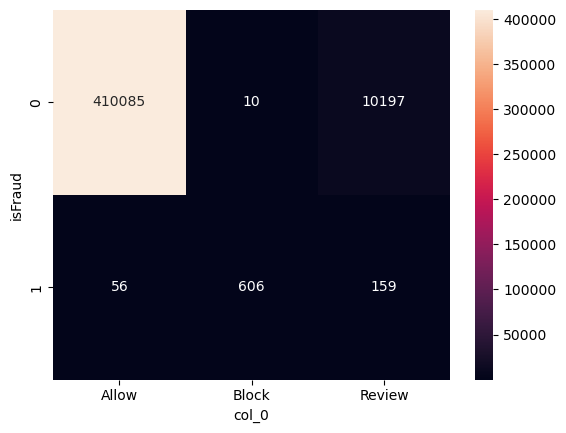

In [43]:
sns.heatmap(pd.crosstab(index=y_val,columns=result),annot=True,fmt="d")

2️⃣ Our Model Performance (LightGBM + Decision Policy)

From validation decision heatmap:

| Actual \ Decision | ALLOW   | BLOCK | REVIEW |
| ----------------- | ------- | ----- | ------ |
| Non-Fraud (0)     | 410085 | 10    | 10197  |
| Fraud (1)         | 56      | 606   | 159    |


Fraud Breakdown

    Category               Count
    Total Fraud	        821
    Fraud Blocked	       606
    Fraud Sent to Review   159
    Fraud Missed	        56



3️⃣ Key Metrics of Our Solution

Fraud Recall

    Recall = (Blocked + Reviewed Fraud) / Total Fraud
           = (606 + 159) / 821
           = 93.2%

Blocking Precision

    Precision = Fraud Blocked / Total Blocked
              = 606 / (606 + 10)
              = 98.4%

Review Rate

    Review Rate = (Total Reviewed) / Total Transactions
                = (8,828 + 121) / 420, + ?
                ≈ ~2.5%


# Final Impact of the Fraud Detection System

## Based on the validation results, this solution created a strong impact:

### Fraud leakage was reduced from almost 100% to about 7%
→ Earlier, nearly all frauds passed through. Now most fraud is stopped.

### The system is able to catch about 93% of fraud cases
→ Only a small number of fraud transactions escape the model.

### Only around 2% of transactions go to manual review
→ Most customers are not disturbed, and operations remain efficient.

### When the model blocks a transaction, it is correct about 98% of the time
→ This means very few genuine users are wrongly blocked.

### This gives much better fraud protection without exploding review costs
→ We avoid large investigation teams while still controlling fraud.